<h1>Atividade 1 - Parte B – Reconhecimento de Imagens e Visão Computacional</h1>

Grupo:<br>
Aderson Lucas Guimarães Mendonça Medeiros<br>
Andrei Ben-Hur do Rego Paz<br> 
Tiago Rocha de Almeida        

1) Escreva um programa em que o limiar seja estimado automaticamente usando a técnica de Global Thresholding. A saída deve ser uma imagem binarizada e a entrada de ser a imagem fingerPrint.png. Qual a relação que existe entre o limiar e o número de iterações?

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# Carregar imagem
image = cv2.imread('../imagens/fingerPrint.png', cv2.IMREAD_GRAYSCALE)

In [14]:
def find_global_threshold(image_fgt, threshold_fgt, error_fgt):
    threshold_initial = threshold_fgt
    threshold_final = -1
    error = threshold_final - threshold_initial
    image_fgt_final = image_fgt.copy()
    i = 0
    while abs(error) > error_fgt:
        upper_class = image_fgt_final[image_fgt_final >= threshold_initial]
        lower_class = image_fgt_final[image_fgt_final < threshold_initial]
        upper_class_mean = 0 if upper_class.size == 0 else np.mean(upper_class)
        lower_class_mean = 0 if lower_class.size == 0 else np.mean(lower_class)    
        threshold_final = np.mean([upper_class_mean, lower_class_mean])
        error = threshold_final - threshold_initial
        threshold_initial = threshold_final
        i += 1
    print('threshold inicial:',threshold_initial)
    print('threshold final:',threshold_final)
    image_fgt_final[image_fgt_final < threshold_final] = 0
    image_fgt_final[image_fgt_final >= threshold_final] = 255
    return image_fgt_final, i

In [15]:
image_binary, iterations = find_global_threshold(image, np.mean(image), 0.5)
image_binary_compare, iterations_compare = find_global_threshold(image, 50.0, 0.5)

threshold inicial: 125.38601930911415
threshold final: 125.38601930911415
threshold inicial: 125.38601930911415
threshold final: 125.38601930911415


2


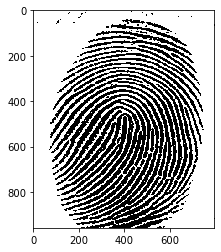

In [16]:
# Mostra a imagem obtida com chute inicial para o limiar de decisão 
# igual a média dos pixels da imagem
plt.imshow(image_binary, cmap='gray')
# Obteve-se uma quantidade de iterações igual a 2
print(iterations)

4


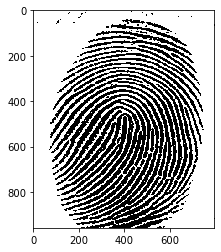

In [17]:
# Mostra a imagem obtida com chute inicial para o limiar de decisão igual a 50
plt.imshow(image_binary_compare, cmap='gray')
# Obteve-se uma quantidade de iterações igual a 4
print(iterations_compare)

(array([ 32922., 167900.,  56406.,  31988.,   2230.,   5096.,  43282.,
         88022., 324050.,  12588.]),
 array([ 29. ,  48.5,  68. ,  87.5, 107. , 126.5, 146. , 165.5, 185. ,
        204.5, 224. ]),
 <a list of 10 Patch objects>)

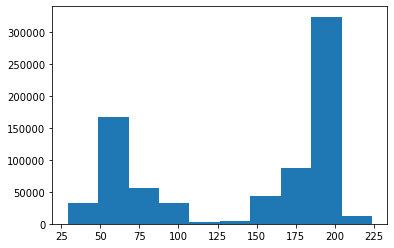

In [18]:
# Histograma para distribuição da intensidade dos pixels
plt.hist(image.flatten())

É possível observar que o chute inicial igual à media dos pixels está mais próximo do divisor final, enquanto o valor de 50 está mais distante.

Resposta: A relação entre o limiar de decisão e a quantidade de iterações é bastante forte, pois dependendo do chute inicial que é dado para o limiar o algoritmo pode convergir de forma muito lenta para o valor global ótimo. Dessa forma, é possível afirmar a relaçao diretamente positiva entre esses dois valores, ou seja, quanto maior o erro no chute inicial maior a quantidade de iterações se torna.

2) A imagem abaixo possui círculos e quadrados de vários tamanhos. Alguns objetos possuem um ou dois buracos dentro deles. Faça um algoritmo que use operações morfológicas e lógicas para responder as perguntas abaixo. 

In [19]:
# Carrega a imagem e normaliza para um intervalo entre 0 e 1
image_shapes = cv2.imread('../imagens/blocks.png', cv2.IMREAD_GRAYSCALE)
thresh, im_binary = \
    cv2.threshold(image_shapes.copy(), 
                  np.min(image_shapes), 
                  np.max(image_shapes), 
                  cv2.THRESH_BINARY)

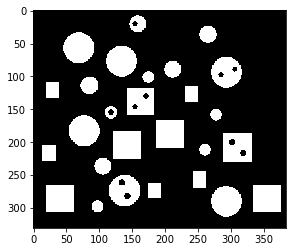

In [20]:
# Show image
plt.imshow(im_binary, cmap='gray')

(a)Que fração dos pixels da imagem são brancos? Quantos objetos a imagem possui? 

In [21]:
# Calcula a proporção de pixels brancos contando o total de pixel brancos e pretos
fracao_branco = np.unique(im_binary, return_counts=True)[1][1]/im_binary.size
print('O percentual de pixels brancos na imagem é: {:.2f}%'.format(100*fracao_branco))

O percentual de pixels brancos na imagem é: 21.25%


In [22]:
# Obter os contornos das formas encontradas e a hierarquia entre os contornos obtidos
contorno, hierarquia = \
    cv2.findContours(im_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
hierarquia = hierarquia.reshape(-1,4)

In [23]:
image_dilated = cv2.dilate(im_binary, np.ones(3), iterations=10)

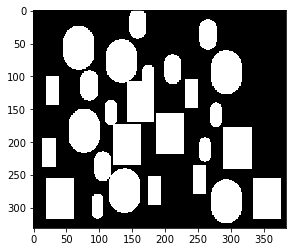

In [24]:
plt.imshow(image_dilated, cmap='gray')

In [25]:
image_shape_array = list()
for shape in contorno:
    shape_reshape = shape.reshape(-1,2)
    x_min = np.min(shape_reshape[:,0]-1)
    x_max = np.max(shape_reshape[:,0]+1)
    y_min = np.min(shape_reshape[:,1]-1)
    y_max = np.max(shape_reshape[:,1]+1)
    image_shape_array.append(image_dilated[y_min:y_max, x_min:x_max])

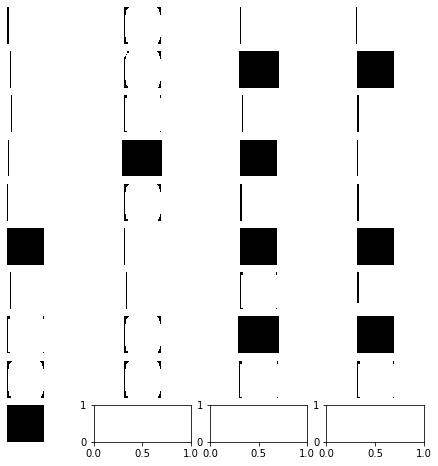

In [26]:
fig, axes = plt.subplots(10, 4, figsize=[8,8])
for ax, image in zip(axes.flatten(), image_shape_array):
    ax.axis('off')
    ax.imshow(image, cmap='gray')

In [27]:
# Utilizando o resultado acima, no qual as imagens não foram transformada em 
# quadrados totalmente pretos, ao contrário dos buracos nessas imagens,
# contaremos o total de imagem 100% pretas.
total_formas_transformacao = \
    [np.size(forma[forma == 255])/np.size(forma) for forma in image_shape_array]
total_formas_transformacao = \
    [forma for forma in total_formas_transformacao if forma != 1.0]
print('Foram encontrados {} objetos.'.format(len(total_formas_transformacao)))

Foram encontrados 27 objetos.


(b)Quantos buracos há na imagem? Quantos objetos têm mais de um buraco? 

In [28]:
# Encontrar os objetos que depois da dilatação, individualização 
# e delimitação espacial possuem 100% de seus pixels pretos.
total_buracos = len(image_shape_array) - len(total_formas_transformacao)
print('Foram encontrados {} objetos.'.format(total_buracos))

Foram encontrados 10 objetos.


In [30]:
# Contar todos os contornos com indice de pai diferente de -1 e
# com o mesmo pai, ou seja, objetos diferentes com mesmo pai.
total_objetos = \
    np.unique([objeto[-1] for objeto in hierarquia if objeto[-1] != -1], 
              return_counts=True)
contagem_objetos = np.unique(total_objetos[1], return_counts=True)
print('Foram encontrados {} objetos com mais de um buraco.'
          .format(contagem_objetos[1][1]))

Foram encontrados 4 objetos com mais de um buraco.
